# Polar Plotting Tutorial

This demonstration will show how to re-project the NEMO velocities for quiver plotting in polar coordinates.

NEMO velocities are usually calculated and saved in along grid i and j directions. This causes an issue when plotting velocities as vectors on a map where it is assumed that i and j velocities point eastwards and northwards but the grid is curvilinear.

There are additional isses when plotting quivers over the poles that we will cover.

The data we use here comes from a global model that has been cropped to the Arctic region. If you want to see the images, please go to the configuration gallery codes in `example_scripts/configuration_gallery/polar_plotting.py` or in the [documentation](https://british-oceanographic-data-centre.github.io/COAsT/docs/examples/configs_gallery/).

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import coast

ModuleNotFoundError: No module named 'matplotlib'

### Usage of coast._utils.plot_util.velocity_grid_to_geo()

Plotting velocities with curvilinear grid and/or on a polar stereographic projection.

In [3]:
root = "../../"
# Paths to a single or multiple data files.
dn_files = root + "example_files/"
fn_nemo_dat_t = dn_files + "coast_nemo_quiver_thetao.nc"
fn_nemo_dat_u = dn_files + "coast_nemo_quiver_uo.nc"
fn_nemo_dat_v = dn_files + "coast_nemo_quiver_vo.nc"
fn_nemo_config_t = root + "config/gc31_nemo_grid_t.json"
fn_nemo_config_u = root + "config/gc31_nemo_grid_u.json"
fn_nemo_config_v = root + "config/gc31_nemo_grid_v.json"

# Set path for domain file if required.
fn_nemo_dom = dn_files + "coast_nemo_quiver_dom.nc"

# Define output filepath (optional: None or str)
fn_out = './quiver_plot.png'

In [4]:
# Read in multiyear data (This example uses NEMO data from a single file.)
nemo_data_t = coast.Gridded(fn_data=fn_nemo_dat_t,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_t,
                          ).dataset
nemo_data_u = coast.Gridded(fn_data=fn_nemo_dat_u,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_u,
                          ).dataset
nemo_data_v = coast.Gridded(fn_data=fn_nemo_dat_v,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_v,
                          ).dataset

Select surface u and v as an example:

In [5]:
# Select specific data variables.
data_u = nemo_data_u[["u_velocity"]]
data_v = nemo_data_v[["v_velocity"]]

# Select one time step and surface currents
data_u = data_u.isel(t_dim=0, z_dim=0)
data_v = data_v.isel(t_dim=0, z_dim=0)

# Calculate speed
speed = ((data_u.to_array().values[0, :, :] ** 2 + data_v.to_array().values[0, :, :] ** 2) ** 0.5)

Calculate adjustment for the curvilinear grid

This function may take a while

In [6]:
uv_velocities = [data_u.to_array().values[0, :, :], data_v.to_array().values[0, :, :]]
u_new, v_new = coast._utils.plot_util.velocity_grid_to_geo(
    nemo_data_t.longitude.values, nemo_data_t.latitude.values, 
    uv_velocities,
    polar_stereo_cartopy_bug_fix=False)

100%|██████████████████████████████████████████████████| 59/59 [02:01<00:00,  2.06s/it]


In [7]:
# Apply the CartoPy stereographic polar correction
# NOTE: This could have been applied automatically with `polar_stereo=True` in
# coast._utils.plot_util.velocity_grid_to_geo()

u_pol, v_pol = coast._utils.plot_util.velocity_polar_bug_fix(u_new, v_new, nemo_data_t.latitude.values)

In [8]:
# Set things up for plotting North Pole stereographic projection

# Data projection
data_crs = ccrs.PlateCarree()
# Plot projection
mrc = ccrs.NorthPolarStereo(central_longitude=0.0)

Below shows the u and v velocities when plotted with and without adjustment.

The plot shows three cases: 1:no correction, 2:the NEMO grid correction, and 3:the NEMO grid correction with polar stereographic plot correction. We also plot the final corrected u and v velocities as streamlines.
- In case 1, the lower latitude velocities aren't too bad but become irregular further north as the grid lines deviate form lat and lon.
- In case 2, the irregularity still persists even with the grid correction. This is the result of a CartoPy bug which also worsens at high latitudes.
- In case 3, both corrections have been applied and the velocities quivers now align with the route of strong current speed as would be expected.

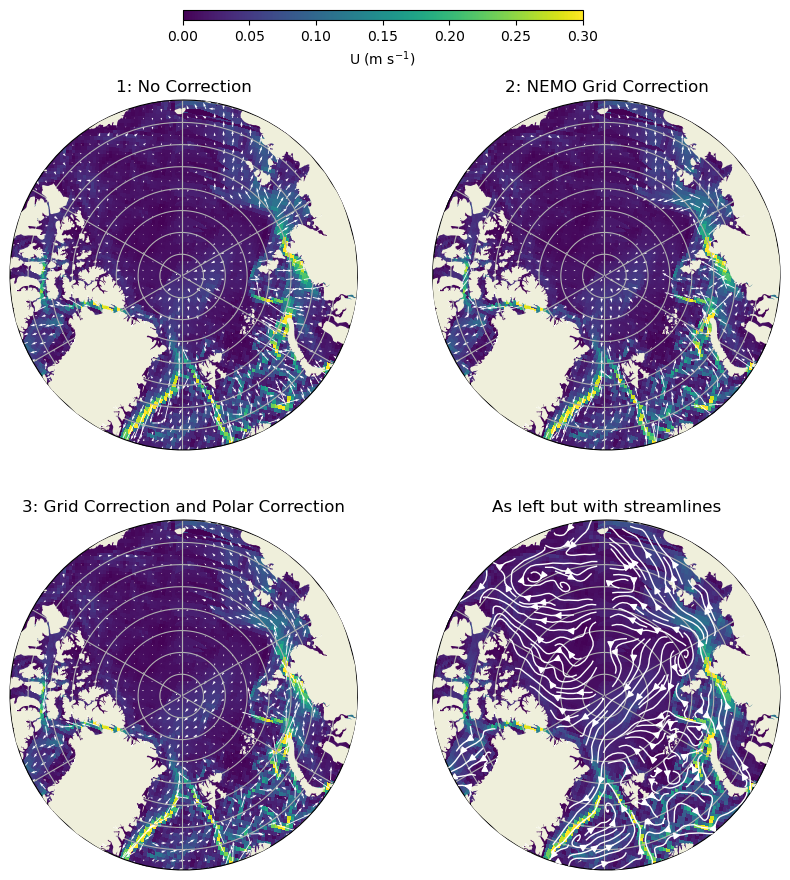

In [9]:
# Subplot axes settings
n_r = 2  # Number of subplot rows
n_c = 2  # Number of subplot columns
figsize = (10, 10)  # Figure size
subplot_padding = 0.5  # Amount of vertical and horizontal padding between plots
fig_pad = (0.075, 0.075, 0.1, 0.1)  # Figure padding (left, top, right, bottom)

# Labels and Titles
fig_title = "Velocity Plot"  # Whole figure title

# Create plot and flatten axis array
fig, ax = plt.subplots(n_r, n_c, subplot_kw={"projection": mrc}, sharey=True, sharex=True, figsize=figsize)
cax = fig.add_axes([0.3, 0.96, 0.4, 0.01])


ax = ax.flatten()
for rr in range(n_r * n_c):
    ax[rr].add_feature(cfeature.LAND, zorder=100)
    ax[rr].gridlines()
    ax[rr].set_extent([-180, 180, 70, 90], crs=data_crs)
    coast._utils.plot_util.set_circle(ax[rr])


cs = ax[0].pcolormesh(nemo_data_t.longitude.values, nemo_data_t.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[0].quiver(nemo_data_t.longitude.values, nemo_data_t.latitude.values, 
    data_u.to_array().values[0, :, :], data_v.to_array().values[0, :, :], 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[1].pcolormesh(nemo_data_t.longitude.values, nemo_data_t.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[1].quiver(nemo_data_t.longitude.values, nemo_data_t.latitude.values, 
    u_new, v_new, 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[2].pcolormesh(nemo_data_t.longitude.values, nemo_data_t.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[2].quiver(nemo_data_t.longitude.values, nemo_data_t.latitude.values, 
    u_pol, v_pol, 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[3].pcolormesh(nemo_data_t.longitude.values, nemo_data_t.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[3].streamplot(nemo_data_t.longitude.values, nemo_data_t.latitude.values, 
    u_pol, v_pol, transform=data_crs, linewidth=1, density=2, color='w', zorder=101)

ax[0].set_title('1: No Correction')
ax[1].set_title('2: NEMO Grid Correction')
ax[2].set_title('3: Grid Correction and Polar Correction')
ax[3].set_title('As left but with streamlines')

fig.colorbar(cs, cax=cax, orientation='horizontal')
cax.set_xlabel('U (m s$^{-1}$)')

#fig.tight_layout(w_pad=subplot_padding, h_pad=subplot_padding)
#fig.subplots_adjust(left=(fig_pad[0]), bottom=(fig_pad[1]), right=(1 - fig_pad[2]), top=(1 - fig_pad[3]))

plt.show()
# uncomment this line to save an output image
fig.savefig(fn_out)

Below shows the temperature plots

In [10]:
# Data to plot
data_bathy = nemo_data_t.bathymetry.values
data_temp = nemo_data_t.temperature.isel(t_dim=0, z_dim=0)

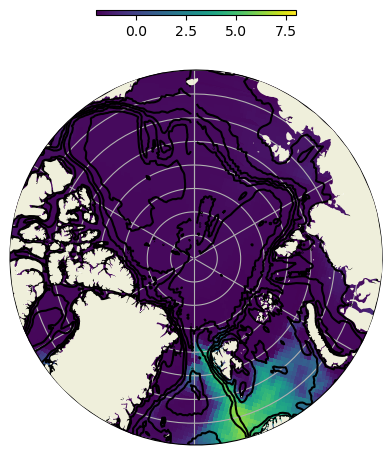

In [11]:
figsize = (5, 5)  # Figure size
fig = plt.figure(figsize=figsize)
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.75], projection=mrc)
cax = fig.add_axes([0.3, 0.96, 0.4, 0.01])

ax1.add_feature(cfeature.LAND, zorder=105)
ax1.gridlines()
ax1.set_extent([-180, 180, 70, 90], crs=data_crs)
coast._utils.plot_util.set_circle(ax1)

# We use to a function to re-project the data for plotting contours over the pole.
cs1 = coast._utils.plot_util.plot_polar_contour(
    nemo_data_t.longitude.values, nemo_data_t.latitude.values, data_bathy, ax1, levels=6, colors="k", zorder=101
)
cs2 = ax1.pcolormesh(
    nemo_data_t.longitude.values, nemo_data_t.latitude.values, data_temp, transform=data_crs, vmin=-2, vmax=8
)
cax.set_xlabel(r"SST ($^{\circ}$C)")
fig.colorbar(cs2, cax=cax, orientation="horizontal")

# fig.savefig(fn_out, dpi=120)
